In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/train.csv')

In [2]:
data

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [3]:
# Drop the ID column
data = data.drop('id', axis=1)

# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract date components
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month 
data['year'] = data['date'].dt.year
data['day_of_week'] = data['date'].dt.dayofweek

# Display the first few rows to verify changes
data.head()


,date,country,store,product,num_sold,day,month,year,day_of_week
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,1,2010,4
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,1,2010,4
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,1,2010,4
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,1,2010,4
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,1,2010,4


In [4]:
# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['country', 'store', 'product']
label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Display first few rows to verify encoding
data.head()


,date,country,store,product,num_sold,day,month,year,day_of_week
0,2010-01-01,0,0,0,NaN,1,1,2010,4
1,2010-01-01,0,0,1,973.0,1,1,2010,4
2,2010-01-01,0,0,2,906.0,1,1,2010,4
3,2010-01-01,0,0,3,423.0,1,1,2010,4
4,2010-01-01,0,0,4,491.0,1,1,2010,4


In [6]:
data.dropna(inplace=True)

### XGBoost Model ###


Fold 1 Metrics:
Mean Squared Error: 4094.34
Root Mean Squared Error: 63.99
Mean Absolute Error: 39.90
R-squared Score: 0.99

Fold 2 Metrics:
Mean Squared Error: 4007.98
Root Mean Squared Error: 63.31
Mean Absolute Error: 39.55
R-squared Score: 0.99

Fold 3 Metrics:
Mean Squared Error: 4167.85
Root Mean Squared Error: 64.56
Mean Absolute Error: 39.98
R-squared Score: 0.99

Fold 4 Metrics:
Mean Squared Error: 4189.04
Root Mean Squared Error: 64.72
Mean Absolute Error: 39.61
R-squared Score: 0.99

Fold 5 Metrics:
Mean Squared Error: 4047.76
Root Mean Squared Error: 63.62
Mean Absolute Error: 39.76
R-squared Score: 0.99

Average Metrics Across All Folds:
Mean Squared Error: 4101.39 (+/- 68.92)
Root Mean Squared Error: 64.04 (+/- 0.54)
Mean Absolute Error: 39.76 (+/- 0.16)
R-squared Score: 0.99 (+/- 0.00)


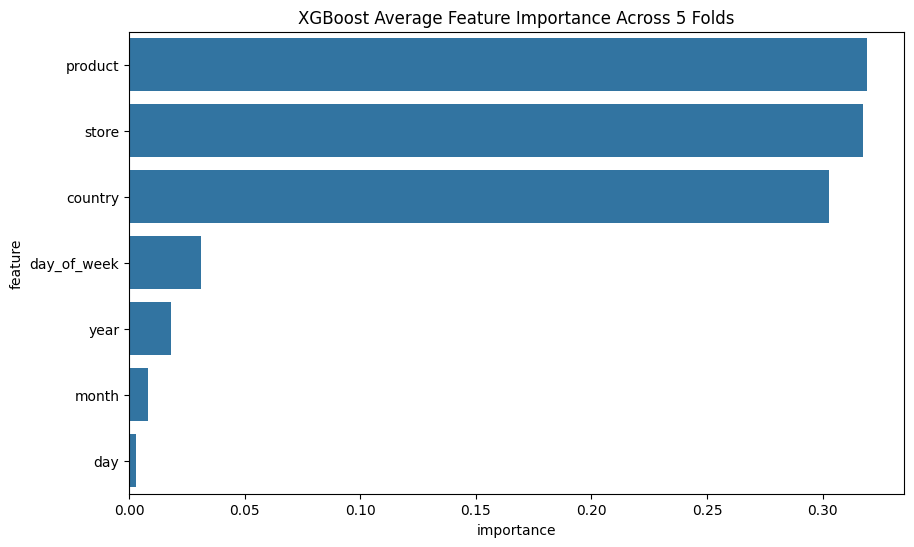

In [8]:
# Split features and target
X = data.drop(['num_sold', 'date'], axis=1)
y = data['num_sold']

# Set up 5-fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
feature_importances = []

# Perform k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Store metrics
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    feature_importances.append(model.feature_importances_)
    
    print(f"\nFold {fold+1} Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R-squared Score: {r2:.2f}")

# Print average metrics across all folds
print("\nAverage Metrics Across All Folds:")
print(f"Mean Squared Error: {np.mean(mse_scores):.2f} (+/- {np.std(mse_scores):.2f})")
print(f"Root Mean Squared Error: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores):.2f})")
print(f"Mean Absolute Error: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})")
print(f"R-squared Score: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})")

# Average feature importance across folds
avg_importance = np.mean(feature_importances, axis=0)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': avg_importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Average Feature Importance Across 5 Folds')
plt.show()



Test Set Metrics (2016-2017):
Mean Squared Error: 8491.88
Root Mean Squared Error: 92.15
Mean Absolute Error: 55.32
R-squared Score: 0.98


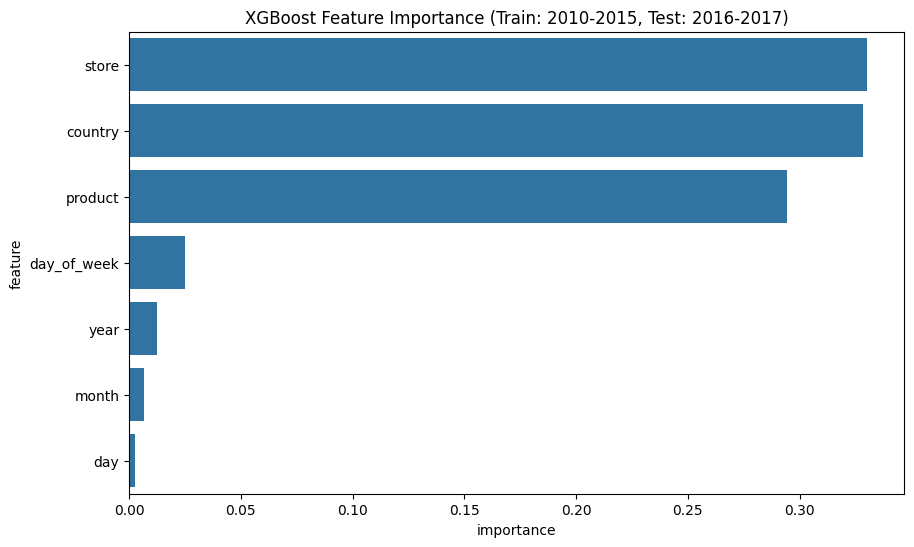

In [13]:
# Split data by date instead of random k-fold
train_data = data[data['year'] <= 2015]
test_data = data[data['year'] > 2015]

X_train = train_data.drop(['num_sold', 'date'], axis=1)
y_train = train_data['num_sold']
X_test = test_data.drop(['num_sold', 'date'], axis=1)
y_test = test_data['num_sold']

# Train model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics (2016-2017):")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance (Train: 2010-2015, Test: 2016-2017)')
plt.show()


### ARIMA Model ###

In [28]:
# Prepare time series data
import statsmodels.tsa.statespace.sarimax as sm

ts_data = data.groupby('date')['num_sold'].mean().reset_index()
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data = ts_data.set_index('date')
ts_data = ts_data.sort_index()

ts_data

,num_sold
date,
2010-01-01,972.340909
2010-01-02,938.045455
2010-01-03,1003.727273
2010-01-04,782.471264
2010-01-05,755.321839
...,...
2016-12-27,733.443182
2016-12-28,808.375000
2016-12-29,879.602273


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92625D+00    |proj g|=  1.13709D-01


 This problem is unconstrained.



At iterate    5    f=  5.74290D+00    |proj g|=  1.54225D-02

At iterate   10    f=  5.71973D+00    |proj g|=  6.14009D-03

At iterate   15    f=  5.58457D+00    |proj g|=  4.95168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     34      1     0     0   9.775D-04   5.583D+00
  F =   5.5833679067803192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

SARIMAX Test Set Metrics (2016):
Mean Squared Error: 7196.22
Root Mean Squared Error: 84.83
Mean Absolute Error: 77.56


<Figure size 1000x600 with 0 Axes>

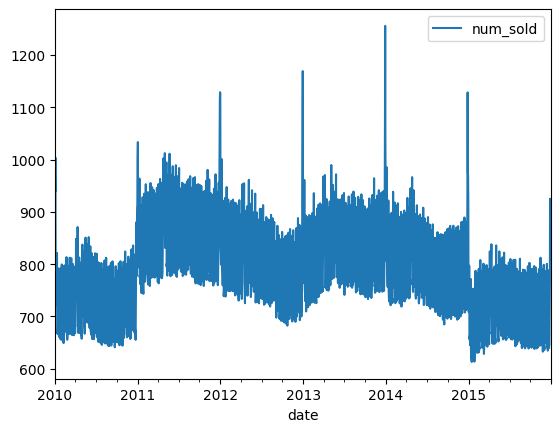

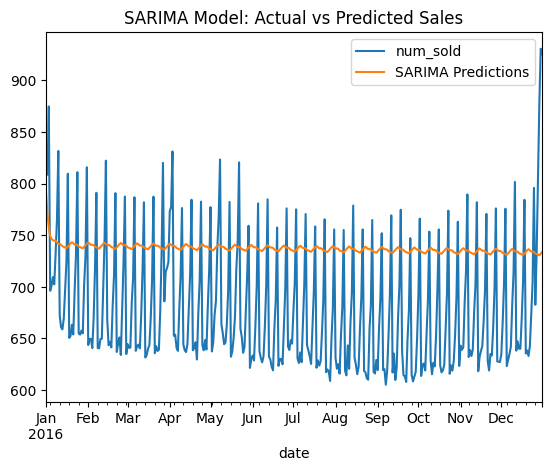

In [29]:
# Split into train and test
train_ts = ts_data[:'2015']
test_ts = ts_data['2016':]

# Fit SARIMAX model
# Using common parameters for seasonal data (12 month seasonality)
model_sarima = sm.SARIMAX(
    train_ts,
    order=(1, 1, 1),  # (p,d,q) - ARIMA parameters
    seasonal_order=(1, 1, 1, 12),  # (P,D,Q,s) - seasonal ARIMA parameters
)

# Train the model
results_sarima = model_sarima.fit()

# Make predictions
forecast = results_sarima.get_forecast(steps=len(test_ts))
predicted_mean = forecast.predicted_mean

# Calculate metrics
mse_sarima = mean_squared_error(test_ts, predicted_mean)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(test_ts, predicted_mean)

print("\nSARIMAX Test Set Metrics (2016):")
print(f"Mean Squared Error: {mse_sarima:.2f}")
print(f"Root Mean Squared Error: {rmse_sarima:.2f}")
print(f"Mean Absolute Error: {mae_sarima:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
train_ts.plot(label='Training Data')
test_ts.plot(label='Test Data')
predicted_mean.plot(label='SARIMA Predictions')
plt.title('SARIMA Model: Actual vs Predicted Sales')
plt.legend()
plt.show()


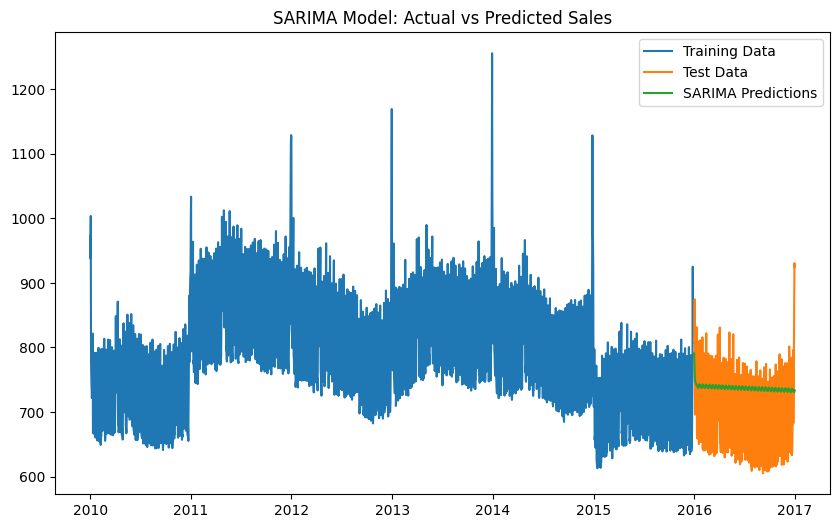

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_ts.index, train_ts['num_sold'], label='Training Data')
plt.plot(test_ts.index, test_ts['num_sold'], label='Test Data')
plt.plot(pred_ts.index, pred_ts['num_sold'], label='SARIMA Predictions')
plt.title('SARIMA Model: Actual vs Predicted Sales')
plt.legend()
plt.show()

In [17]:
test_ts

,num_sold
date,
2016-01-01,706.0
2016-01-01,634.0
2016-01-01,316.0
2016-01-01,404.0
2016-01-01,238.0
...,...
2016-12-31,466.0
2016-12-31,2907.0
2016-12-31,2299.0


In [31]:
pred_ts = test_ts.copy()
pred_ts['num_sold'] = list(predicted_mean)

In [23]:
predicted_mean

189492    1325.003208
189493    1347.729487
189494    1378.545523
189495    1151.894993
189496    1187.733137
             ...     
221254    1324.795702
221255    1327.121728
221256    1322.479282
221257    1324.304584
221258    1324.264808
Name: predicted_mean, Length: 31767, dtype: float64

In [24]:
pred_ts

,num_sold
date,
2016-01-01,1325.003208
2016-01-01,1347.729487
2016-01-01,1378.545523
2016-01-01,1151.894993
2016-01-01,1187.733137
...,...
2016-12-31,1324.795702
2016-12-31,1327.121728
2016-12-31,1322.479282
